# Age Classification Result

## Welcome!

This notebook will demonstrate my project results.<br>

## If you're bored later on:
http://chr1snet.de:8050<br>
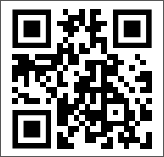

## Initializing...

Nothing interesting to see here...

In [1]:
import os
import pandas as pd
import numpy as np
import joblib
import random
from sklearn.model_selection import train_test_split
import shap
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.tree import plot_tree

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio

In [2]:
random_seed = 42
age_bins = [20, 30, 40, 50, 60, 70, 80]

In [3]:
def evaluate_model_classification(model, X_train, X_test, y_train, y_test, ax=None, title="Confusion Matrix"):
    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Probabilities for each class
    y_proba_train = model.predict_proba(X_train)
    y_proba_test = model.predict_proba(X_test)
    
    # Print accuracy scores
    print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
    print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
    
    # Confusion matrix
    conf = confusion_matrix(y_test, y_pred_test) / y_test.shape[0]
    #print("Confusion Matrix:\n", conf)
    
    # Plot confusion matrix (use provided ax or create a new one)
    if ax is None:
        plt.figure(figsize=(8, 6))
        ax = plt.gca()
    
    sns.heatmap(
        conf,
        annot=True,
        cmap="Blues",
        xticklabels=age_bins,  # Make sure `age_bins` is defined elsewhere
        yticklabels=age_bins,
        ax=ax  # Plot on the provided axis
    )

    ax.set_xlabel("Predicted Age Group")
    ax.set_ylabel("True Age Group")
    ax.set_title(title)

def plot_roc_curves(model, X_test, y_test, ax=None, title="Multi-class ROC Curves (Labels 0-6)"):
    # Get predicted probabilities
    y_proba_test = model.predict_proba(X_test)

    # Binarize the output for ROC curve (One-vs-Rest)
    y_test_bin = label_binarize(y_test, classes=np.arange(0, 7))  # Now 0-6
    n_classes = y_test_bin.shape[1]
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba_test[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_proba_test.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Compute macro-average ROC curve
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # Create figure/axis if not provided
    if ax is None:
        plt.figure(figsize=(10, 8))
        ax = plt.gca()
    
    # Plot all ROC curves on the given axis
    # Micro-average
    # trating as binary classification for micro-average
    ax.plot(fpr["micro"], tpr["micro"],
            label='Micro-average ROC (AUC = {0:0.2f})'.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)
    
    # Macro-average
    # curve interpolation for macro-average
    ax.plot(fpr["macro"], tpr["macro"],
            label='Macro-average ROC (AUC = {0:0.2f})'.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)
    
    # Individual classes
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink']
    for i, color in zip(range(n_classes), colors):
        ax.plot(fpr[i], tpr[i], color=color, lw=2,
                label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))
    
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc="lower right")

In [4]:
audio_src_path = "/run/media/chr1s/chr1sdrive1/uni/SAudio/datasets/CV/en/clips/"
base_data_path = "/run/media/chr1s/chr1sdrive1/uni/SAudio/data/"
voice_path = f"{base_data_path}voices.csv"
features_path = f"{base_data_path}features.csv"
rf_age_path = f"{base_data_path}models/randomforest_age_classifier/randomforest_age_classifier.joblib"
rf_age_gender_path = f"{base_data_path}models/randomforest_age_classifier_gender/randomforest_age_classifier.joblib"
shap_values_age_path = f"{base_data_path}shap_values/randomforest_age_classifier/shap_values.npy"
shap_values_age_gender_path = f"{base_data_path}shap_values/randomforest_age_classifier_gender/shap_values.npy"
shap_interaction_values_age_gender_path = f"{base_data_path}shap_values/randomforest_age_classifier_gender/shap_interaction_values.npy"

In [5]:
voices = pd.read_csv(voice_path, index_col="clip_id").drop(columns=["voice_age", "features_extracted"])
features = pd.read_csv(features_path, index_col="clip_id")
rf_age = joblib.load(rf_age_path)
rf_age_gender = joblib.load(rf_age_gender_path)

# The Data

...provided by the [Mozilla Common Voice](https://commonvoice.mozilla.org/de) project.

In [6]:
random_row = voices.sample(n=1).iloc[0]

audio_file = os.path.join(audio_src_path, random_row.audio_file_name)
Audio(audio_file) 

In [7]:
voices.head()

,audio_file_name,voice_name,voice_age_group,voice_gender
clip_id,,,,
3d060d83-adbd-44e0-afce-b826aa5381b1,common_voice_en_19666343.mp3,20_m_0b062,20.0,m
ecd475b2-3015-4ce5-a2fe-81534bf945b0,common_voice_en_23711401.mp3,30_m_89b1e,30.0,m
01374f0c-ff48-4663-a42d-08c4f184e299,common_voice_en_27285325.mp3,30_m_b229e,30.0,m
4c985ac7-9e16-4dc9-9c45-2127a16fe7fe,common_voice_en_216280.mp3,20_m_6603d,20.0,m
e878a03f-b309-4197-8e87-40b42e5c431d,common_voice_en_35888106.mp3,30_m_bdd6a,30.0,m


In [8]:
voices.info()

<class 'pandas.core.frame.DataFrame'>
Index: 543806 entries, 3d060d83-adbd-44e0-afce-b826aa5381b1 to d404b5ff-b802-42d5-b5e3-1c6acb37acc9
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   audio_file_name  543806 non-null  object 
 1   voice_name       543806 non-null  object 
 2   voice_age_group  543806 non-null  float64
 3   voice_gender     543806 non-null  object 
dtypes: float64(1), object(3)
memory usage: 20.7+ MB


voice_age_group
20.0    233029
30.0    121920
40.0     70728
50.0     56769
60.0     53183
70.0      7509
80.0       632
90.0        36
Name: count, dtype: int64


/tmp/ipykernel_840/936218239.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


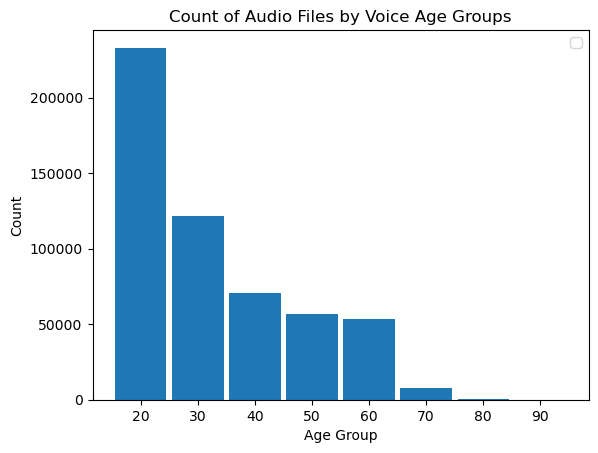

In [9]:
print(voices.voice_age_group.value_counts())

fig, ax = plt.subplots()

ax.bar(voices.voice_age_group.value_counts().index, voices.voice_age_group.value_counts().values, width=9)

ax.set_xlabel('Age Group')
ax.set_ylabel('Count')
ax.set_title('Count of Audio Files by Voice Age Groups')
ax.legend()
plt.show()

In [10]:
data = voices.merge(features, left_index=True, right_index=True, how='inner')
data.loc[data.voice_age_group == 90, "voice_age_group"] = 80
data = data.groupby('voice_age_group', group_keys=False).apply(
    lambda x: x.sample(n=2000, replace=True, random_state=42)
).sample(frac=1, random_state=42)
data["voice_gender_m"] =  (data.voice_gender == "m") * 1
voices = data[voices.columns.to_list() + ["voice_gender_m"]]
features = data[features.columns.to_list()]

/tmp/ipykernel_840/3265482090.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('voice_age_group', group_keys=False).apply(


In [11]:
voices.voice_gender_m.head()

clip_id
0d8a8786-54d8-470f-b922-5cc459d94e04    0
42bfb072-f934-4065-96c9-03dddb6642f5    0
17858317-19fc-4062-b799-659cac23f857    0
f341a4e5-65c6-4d81-9eb4-3be7b86e9887    1
9452f5b8-4c5b-4a02-b53f-c39e607172f2    0
Name: voice_gender_m, dtype: int64

voice_age_group
30.0    2000
60.0    2000
50.0    2000
70.0    2000
40.0    2000
80.0    2000
20.0    2000
Name: count, dtype: int64


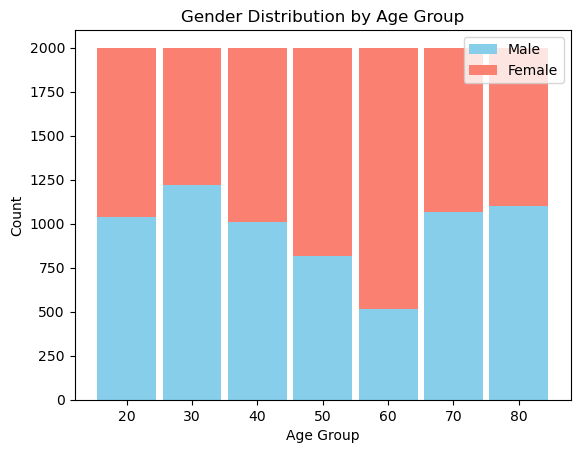

In [12]:
print(voices.voice_age_group.value_counts())

age_counts = voices.voice_age_group.value_counts().sort_index()
age_groups = age_counts.index

gender_by_age = voices.groupby(['voice_age_group', 'voice_gender_m']).size().unstack()
fig, ax = plt.subplots()
colors = {1: 'skyblue', 0: 'salmon'}  # Switched the colors to match typical gender color conventions
bottom = np.zeros(len(age_groups))
for gender, color in colors.items():
    if gender in gender_by_age.columns:
        counts = gender_by_age[gender].reindex(age_groups, fill_value=0)
        ax.bar(age_groups, counts, bottom=bottom, color=color, 
               label='Male' if gender == 1 else 'Female',  # This is correct based on your data
               width=9)
        bottom += counts
ax.set_xlabel('Age Group')
ax.set_ylabel('Count')
ax.set_title('Gender Distribution by Age Group')
ax.legend()
plt.show()

# Feature Extraction

powered by [OpenSMILE](https://audeering.github.io/opensmile-python/) using the [GeMAPS](https://mediatum.ub.tum.de/doc/1523509/file.pdf) featrure set.

In [13]:
rand_voice = voices.iloc[random.randint(0, len(voices) - 1)]
print(rand_voice.to_string())
rand_voice_features = features.loc[[rand_voice.name]]
print(rand_voice_features.to_string())
Audio(os.path.join(audio_src_path, f"{rand_voice.audio_file_name}"))

audio_file_name    common_voice_en_28711101.mp3
voice_name                           50_m_af35c
voice_age_group                            50.0
voice_gender                                  m
voice_gender_m                                1
                                      F0semitoneFrom27.5Hz_sma3nz_amean  F0semitoneFrom27.5Hz_sma3nz_stddevNorm  F0semitoneFrom27.5Hz_sma3nz_percentile20.0  F0semitoneFrom27.5Hz_sma3nz_percentile50.0  F0semitoneFrom27.5Hz_sma3nz_percentile80.0  F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2  F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope  F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope  F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope  F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope  loudness_sma3_amean  loudness_sma3_stddevNorm  loudness_sma3_percentile20.0  loudness_sma3_percentile50.0  loudness_sma3_percentile80.0  loudness_sma3_pctlrange0-2  loudness_sma3_meanRisingSlope  loudness_sma3_stddevRisingSlope  loudness_sma3_meanFallingSlope  loudness_sma3_stddevFallin

In [14]:
features.head()

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
clip_id,,,,,,,,,,,,,,,,,,,,,
0d8a8786-54d8-470f-b922-5cc459d94e04,33.259449,0.171682,29.235744,32.249416,35.426971,6.191227,192.894608,244.725311,77.038849,63.401012,...,0.057318,0.003839,0.317962,3.742204,2.941177,0.123571,0.078158,0.225833,0.279388,-22.604340
42bfb072-f934-4065-96c9-03dddb6642f5,37.109619,0.206593,32.399002,36.596573,43.073315,10.674313,708.863342,951.328247,608.329956,1164.720093,...,0.026710,0.008616,0.123178,1.612903,2.803739,0.163333,0.145736,0.173333,0.193319,-24.661402
17858317-19fc-4062-b799-659cac23f857,32.220005,0.250238,27.960592,30.358505,33.539734,5.579142,434.908264,450.285278,116.315628,163.251328,...,0.041993,0.019698,0.142503,3.296704,2.825553,0.158261,0.127677,0.210526,0.273043,-21.649761
f341a4e5-65c6-4d81-9eb4-3be7b86e9887,33.427921,0.289947,27.610504,29.661760,49.012127,21.401623,204.223709,159.413849,58.931229,67.356728,...,0.092049,0.008741,0.045316,2.358491,0.966184,0.480000,0.250000,0.353333,0.165798,-22.401571
9452f5b8-4c5b-4a02-b53f-c39e607172f2,31.210817,0.110192,29.360758,31.052504,33.051998,3.691240,499.958832,310.663635,50.943298,50.812332,...,0.068632,0.010905,0.017029,3.539823,2.290076,0.193333,0.147761,0.211053,0.370489,-47.665073


# Model Training

## ...and evaluation

In [15]:
X = features
X_g = X.copy()
X_g["voice_gender_m"] = voices.voice_gender_m
y = voices.voice_age_group
y = np.digitize(y, age_bins) - 1

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_g_train, X_g_test, y_g_train, y_g_test = train_test_split(X_g, y, test_size=0.2, random_state=42)

## Random Forest Models

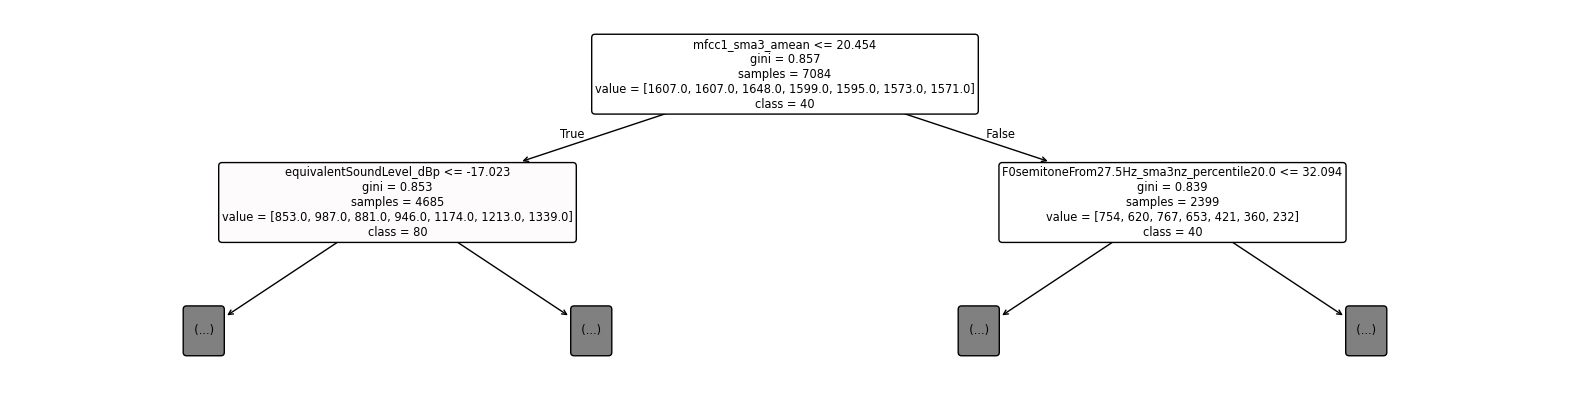

In [17]:
plt.figure(figsize=(20, 5))
plot_tree(rf_age.estimators_[0], 
          feature_names=X.columns, 
          class_names=[str(a) for a in age_bins],
          max_depth=1,
          filled=True, rounded=True)
plt.show()

## Model Evaluation

### 1. most likely guess

In [18]:
y_pred = rf_age.predict(X_test)
[age_bins[i] for i in y_pred[:10]]

[30, 60, 30, 80, 60, 60, 70, 70, 30, 50]

In [19]:
i = np.random.randint(0, len(X_test))
clip_id = X_test.index[i]
true_label = y_test[i]
pred_label = rf_age.predict(X_test.iloc[[i]])[0]

print(f"\nClip ID: {clip_id}")
print(f"True label: {true_label} ({age_bins[true_label]})")
print(f"Predicted: {pred_label} ({age_bins[pred_label]})")


Clip ID: f8db122e-e86f-4941-a9e6-10521afafb50
True label: 6 (80)
Predicted: 6 (80)


Random Forest Age Classifier:
Train Accuracy: 0.8383928571428572
Test Accuracy: 0.5614285714285714

Random Forest Age Gender Classifier:
Train Accuracy: 0.8558928571428571
Test Accuracy: 0.5753571428571429


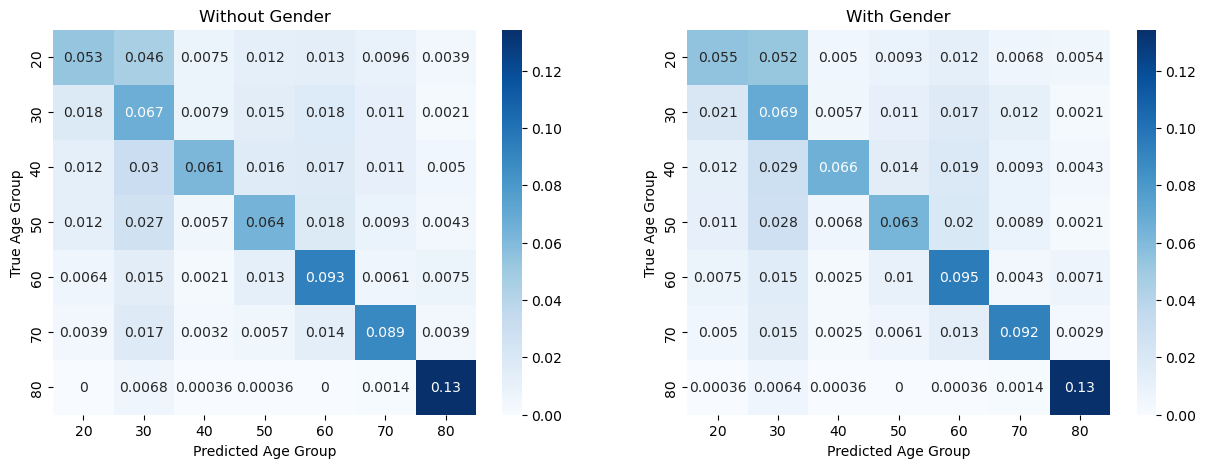

In [20]:
fig, ax = plt.subplots(figsize=(15, 5), ncols=2) 

print("Random Forest Age Classifier:")
evaluate_model_classification(rf_age, X_train, X_test, y_train, y_test, ax=ax[0], title="Without Gender")
print("\nRandom Forest Age Gender Classifier:")
evaluate_model_classification(rf_age_gender, X_g_train, X_g_test, y_g_train, y_g_test, ax=ax[1], title="With Gender")

plt.show()

### 2. probablities

In [21]:
i = np.random.randint(0, len(X_test))
clip_id = X_test.index[i]
true_label = y_test[i]
pred_label = rf_age.predict(X_test.iloc[[i]])[0]
pred_proba = rf_age.predict_proba(X_test.iloc[[i]])[0]

print(f"\nClip ID: {clip_id}")
print(f"True label: {true_label} ({age_bins[true_label]})")
print(f"Predicted: {pred_label} ({age_bins[pred_label]})")
print("Class probabilities:")
for class_idx, prob in enumerate(pred_proba):
    print(f"Class {age_bins[class_idx]}: {prob:.4f}")


Clip ID: cf4c664b-7967-4c59-8faf-af45f578428e
True label: 2 (40)
Predicted: 2 (40)
Class probabilities:
Class 20: 0.0336
Class 30: 0.0480
Class 40: 0.7780
Class 50: 0.0435
Class 60: 0.0256
Class 70: 0.0195
Class 80: 0.0518


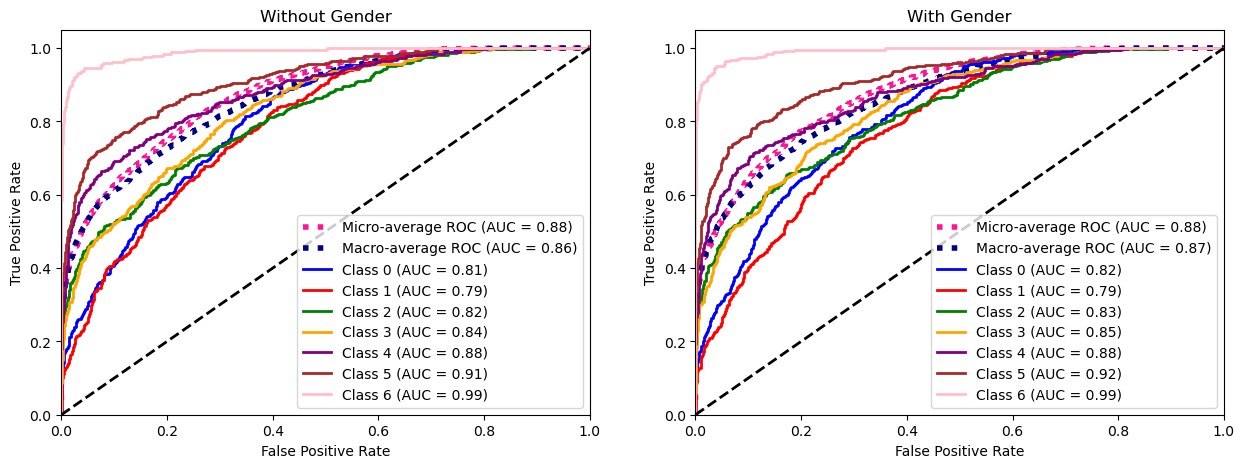

In [22]:
fig, ax = plt.subplots(figsize=(15, 5), ncols=2) 

plot_roc_curves(rf_age, X_test, y_test, ax=ax[0], title="Without Gender")
plot_roc_curves(rf_age_gender, X_g_test, y_g_test, ax=ax[1], title="With Gender")

# SHAP Explainations

In [23]:
X_g_train, X_g_test, y_g_train, y_g_test = train_test_split(X_g, y, test_size=200, random_state=42)

In [24]:
explainer = shap.TreeExplainer(rf_age_gender)
shap_values_age_gender = explainer.shap_values(X_g_test)

## Local Explanation

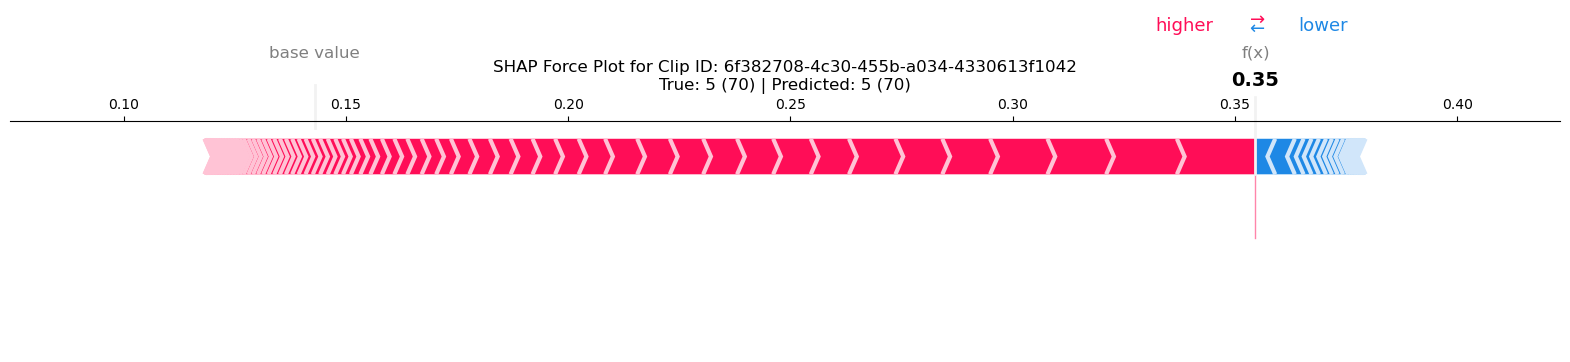

In [29]:
i = np.random.randint(0, len(X_g_test))
shap_values_i = shap_values_age_gender[i]
clip_id = X_g_test.index[i]
true_label = y_test[i]
pred_label = rf_age_gender.predict(X_g_test.iloc[[i]])[0]
pred_proba = rf_age_gender.predict_proba(X_g_test.iloc[[i]])[0]


shap.force_plot(
    explainer.expected_value[pred_label],
    shap_values_i[:,pred_label],
    X_g_test.iloc[i,:],
    feature_names=X_g_test.columns,
    matplotlib=True,
    contribution_threshold=0.08,
    show=False
)
# set range from 0 to 1

plt.title(f"SHAP Force Plot for Clip ID: {clip_id}\nTrue: {true_label} ({age_bins[true_label]}) | Predicted: {pred_label} ({age_bins[pred_label]})")
plt.show()

## Global Explanation

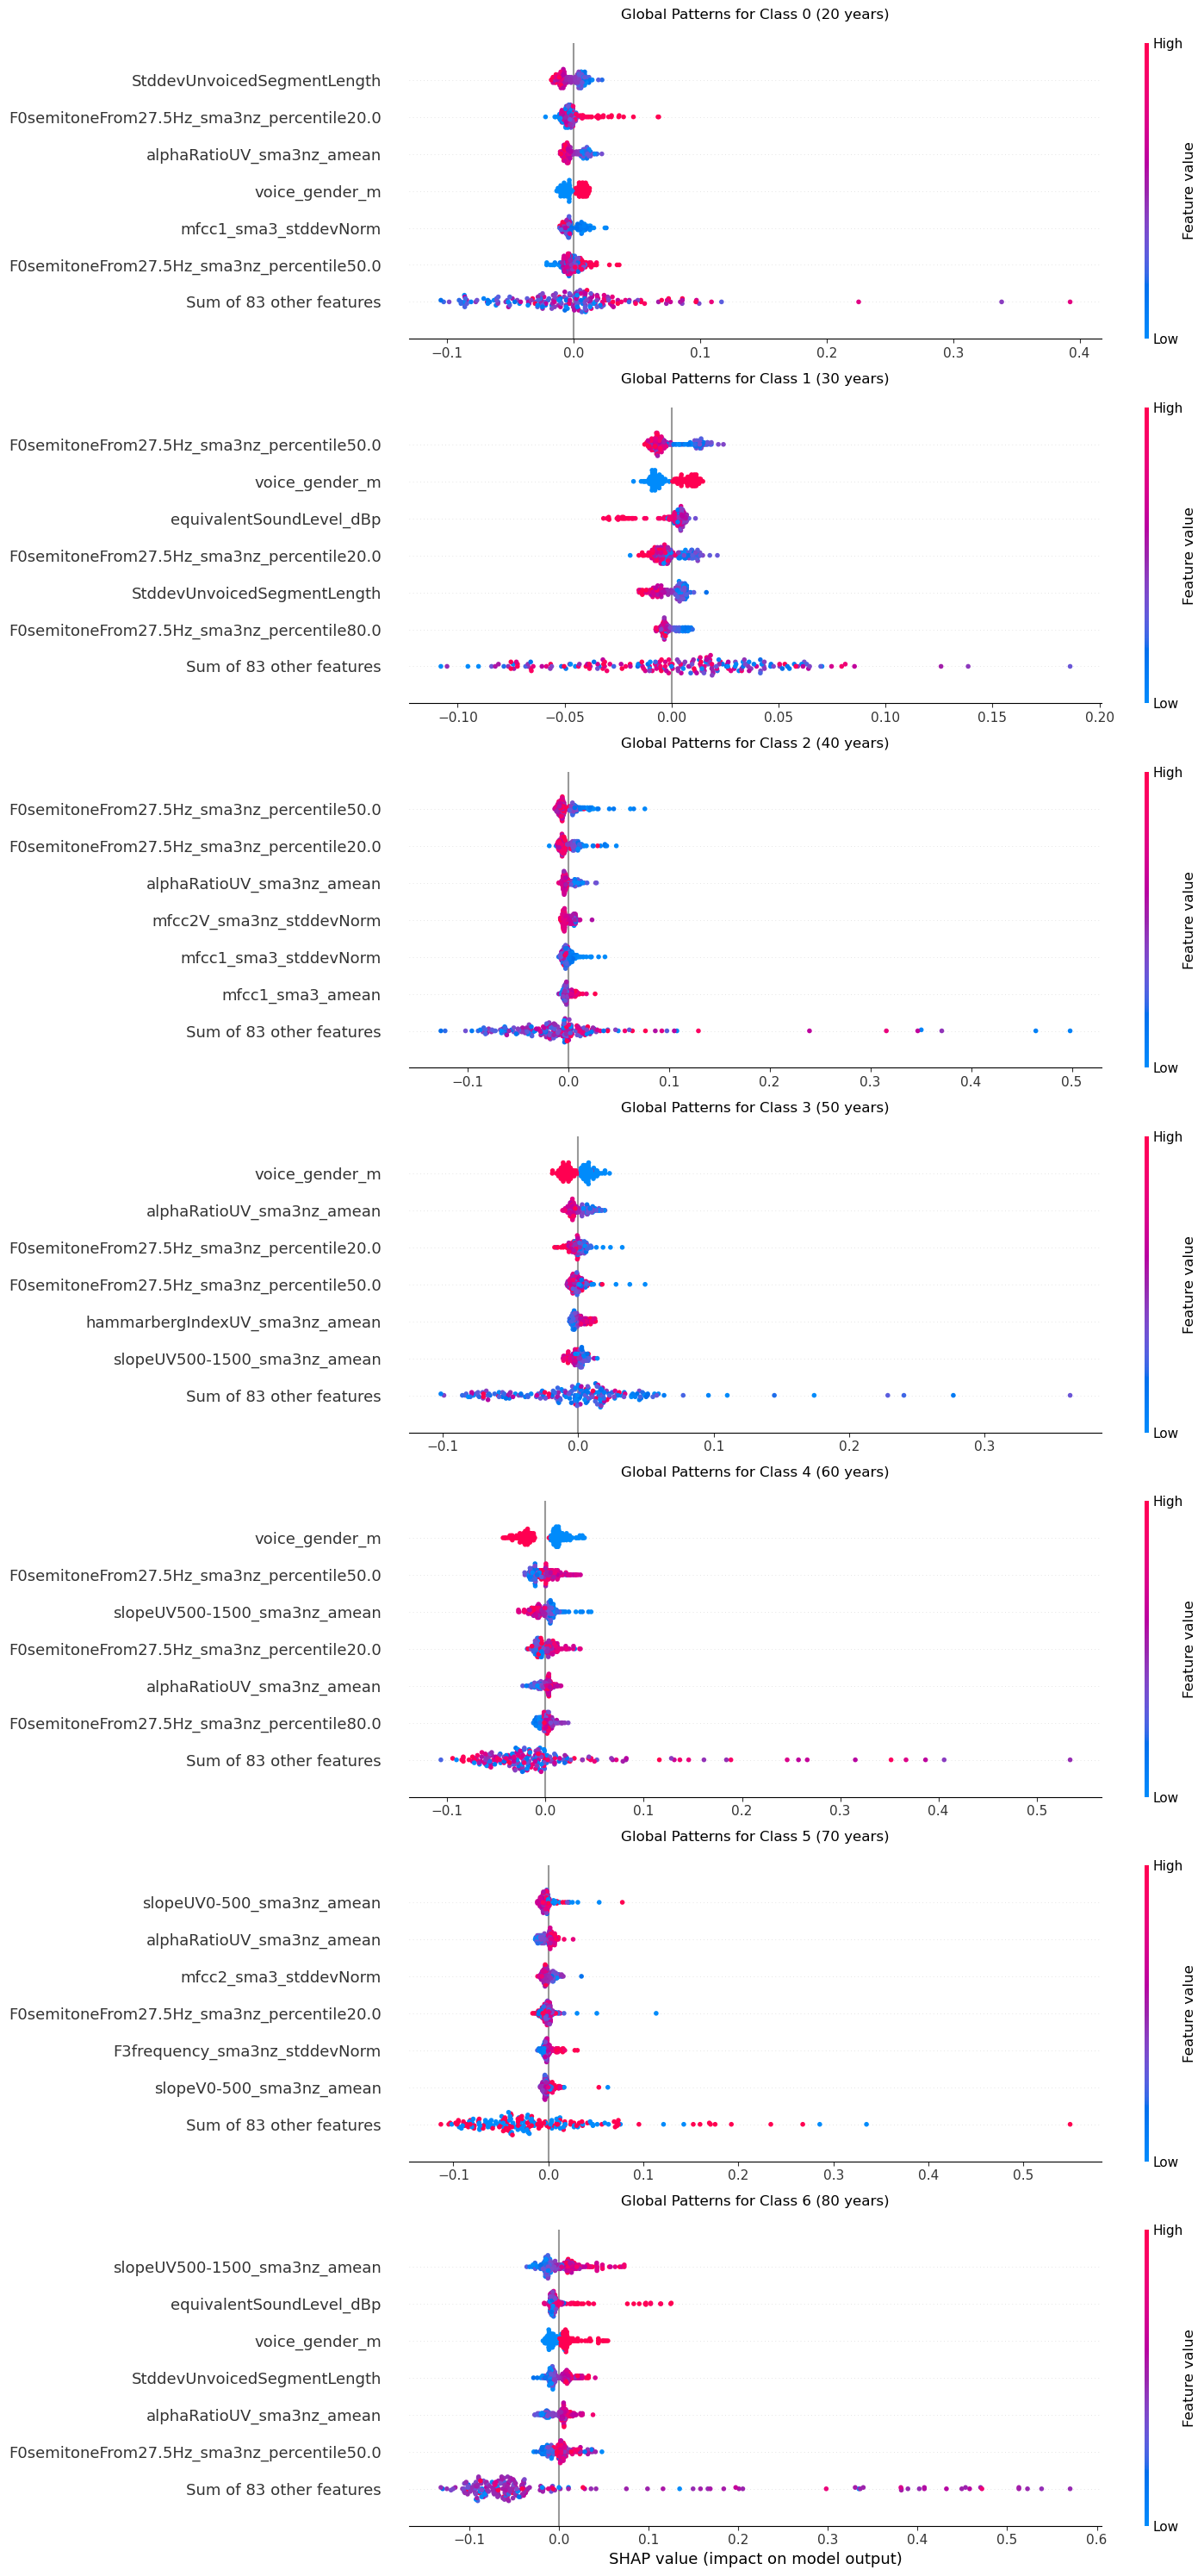

In [30]:
fig, axes = plt.subplots(7, 1, figsize=(15, 30))

for label in range(7):
    explanation = shap.Explanation(
        values=shap_values_age_gender[:, :, label],
        base_values=np.zeros(shap_values_age_gender.shape[0]),
        data=X_g_test.values,
        feature_names=X_g_test.columns.tolist()
    )
    shap.plots.beeswarm(explanation, max_display=7, show=False, plot_size=None, ax=axes[label])
    axes[label].set_title(f"Global Patterns for Class {label} ({age_bins[label]} years)", pad=20)

    if label != 6:
        axes[label].set_xlabel('')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

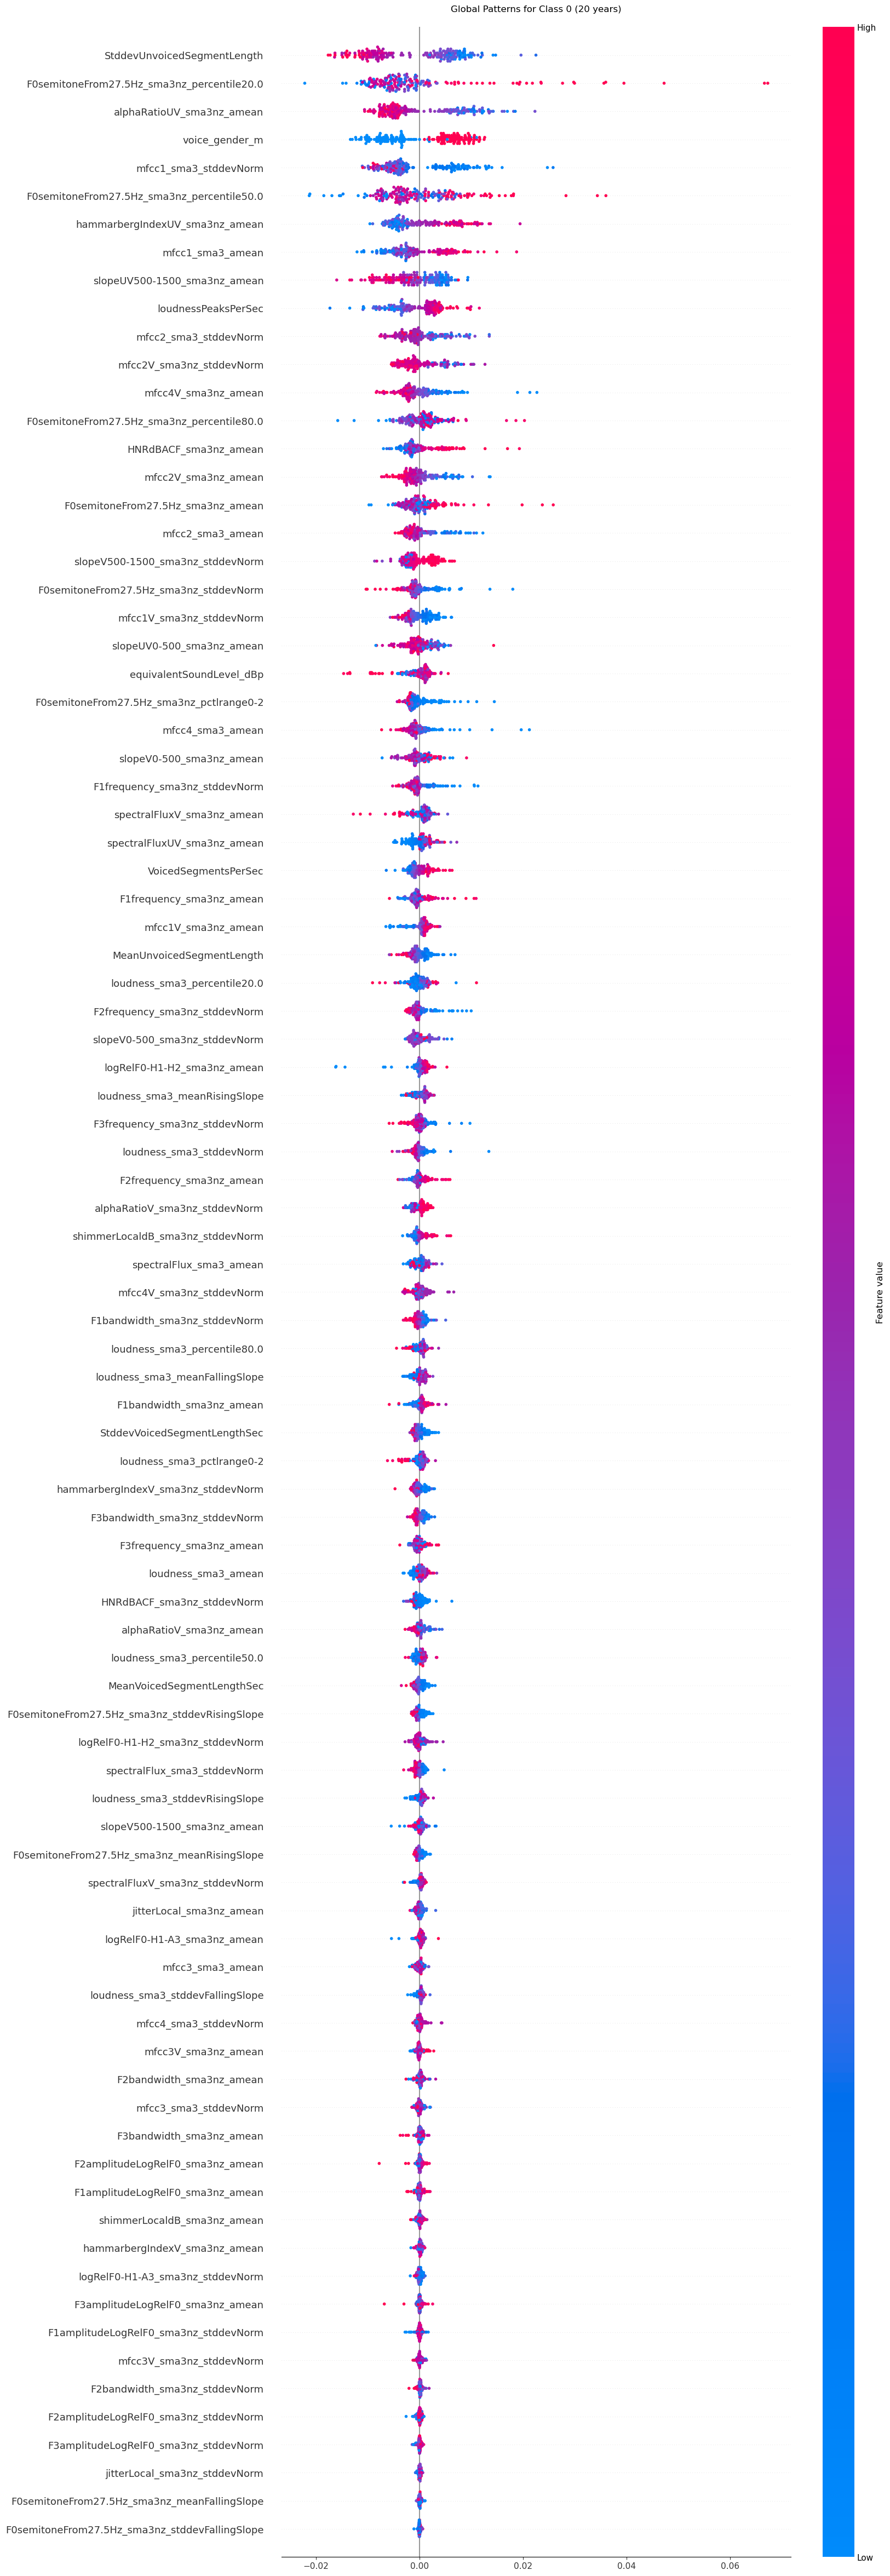

In [31]:
fig, axes = plt.subplots(1, 1, figsize=(15, 60))

label = 0
explanation = shap.Explanation(
    values=shap_values_age_gender[:, :, label],
    base_values=np.zeros(shap_values_age_gender.shape[0]),
    data=X_g_test.values,
    feature_names=X_g_test.columns.tolist()
)
shap.plots.beeswarm(explanation, max_display=89, show=False, plot_size=None, ax=axes)
axes.set_title(f"Global Patterns for Class {label} ({age_bins[label]} years)", pad=20)

if label != 6:
    axes.set_xlabel('')

plt.show()

## Feature Importance Values

In [32]:
shap_array = np.array(
    [
        X_g_test.values * sh_val / (np.abs(X_g_test.values)+0.00001)
        for sh_val in shap_values_age_gender.transpose(2, 0, 1) 
    ]
)
shap_array = shap_array.transpose(1, 2, 0)

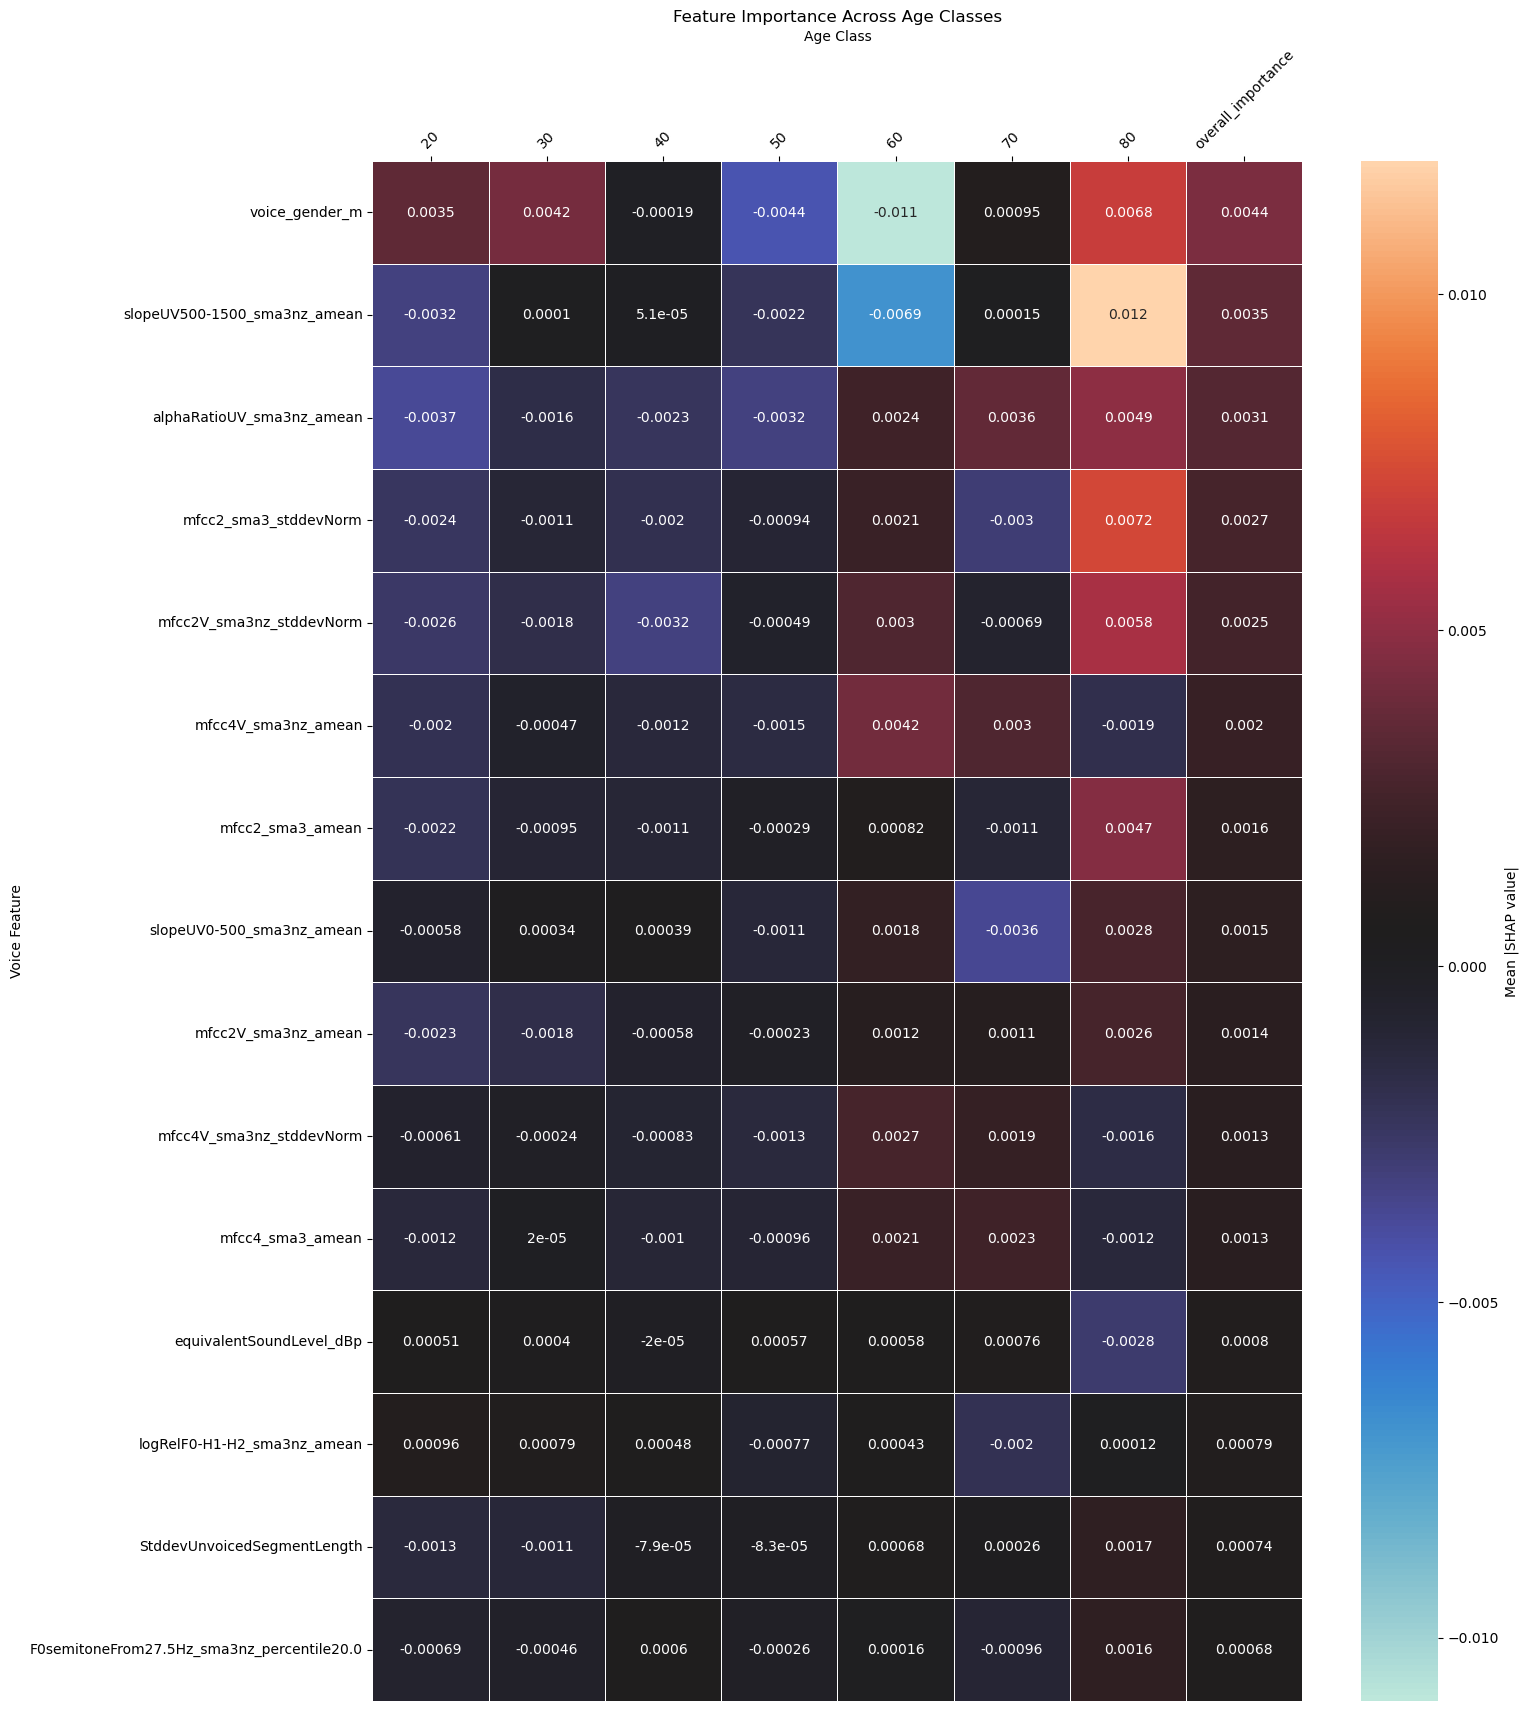

In [33]:
y_pred = rf_age_gender.predict(X_g_test)

class_shap_dict = {}
for i in range(7):
    class_shap_dict[age_bins[i]] = shap_array[:, :, i].mean(axis=0)

importance_df = pd.DataFrame(class_shap_dict, index=X_g_test.columns)
importance_df['overall_importance'] = importance_df.abs().mean(axis=1)
top_15_features = importance_df.nlargest(15, 'overall_importance')

plt.figure(figsize=(15, 20))
ax = sns.heatmap(
    top_15_features,
    cmap="icefire",
    annot=True,
    linewidths=0.5,
    cbar_kws={'label': 'Mean |SHAP value|'},
)
plt.title("Feature Importance Across Age Classes")
ax.xaxis.tick_top()
plt.xticks(rotation=45)
ax.xaxis.set_label_position('top')
plt.xlabel("Age Class")
plt.ylabel("Voice Feature")
plt.show()

## Shap Interaction Values

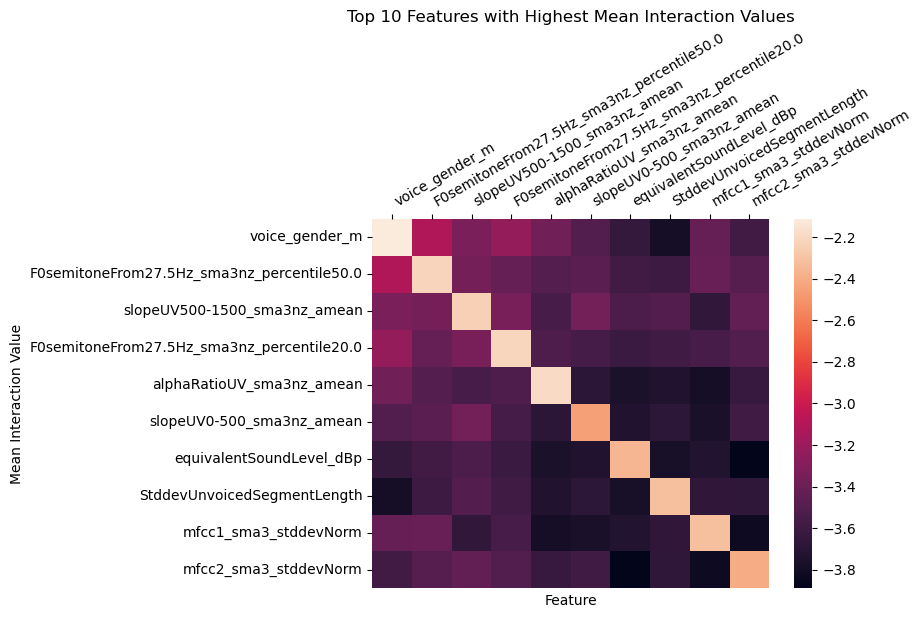

In [34]:
num_features_to_show = 10

shap_interaction_values = np.load(shap_interaction_values_age_gender_path)
mean_interaction_values = np.mean(np.mean(np.abs(shap_interaction_values), axis=0), axis=2)

def calculate_feature_mean_interaction_value(f):
    f_index = X_g_test.columns.get_loc(f)
    ax_0_sum = np.sum(mean_interaction_values[f_index,:]) - mean_interaction_values[f_index,f_index]
    ax_1_sum = np.sum(mean_interaction_values[:,f_index]) - mean_interaction_values[f_index,f_index]
    feature_mean_interaction = (ax_0_sum + ax_1_sum)# / (2*mean_interaction_values.shape[0])
    return feature_mean_interaction

feature_mean_interaction_values = pd.Series({
    f: calculate_feature_mean_interaction_value(f)
    for f in X_g_test.columns.to_list()
}).sort_values(ascending=False)
main_interaction_features = feature_mean_interaction_values.head(num_features_to_show)

idxs = [X_g_test.columns.get_loc(f) for f in main_interaction_features.index.to_list()]
interaction_matrix = mean_interaction_values[idxs].T[idxs]

ax = sns.heatmap(
    np.log10(interaction_matrix), 
    yticklabels=main_interaction_features.index,
    xticklabels=main_interaction_features.index,
)
plt.title(f"Top {num_features_to_show} Features with Highest Mean Interaction Values")
ax.set_xlabel("Feature")
ax.set_ylabel("Mean Interaction Value")
ax.xaxis.tick_top()
plt.setp(ax.get_xticklabels(), rotation=30, ha='left')
plt.show()

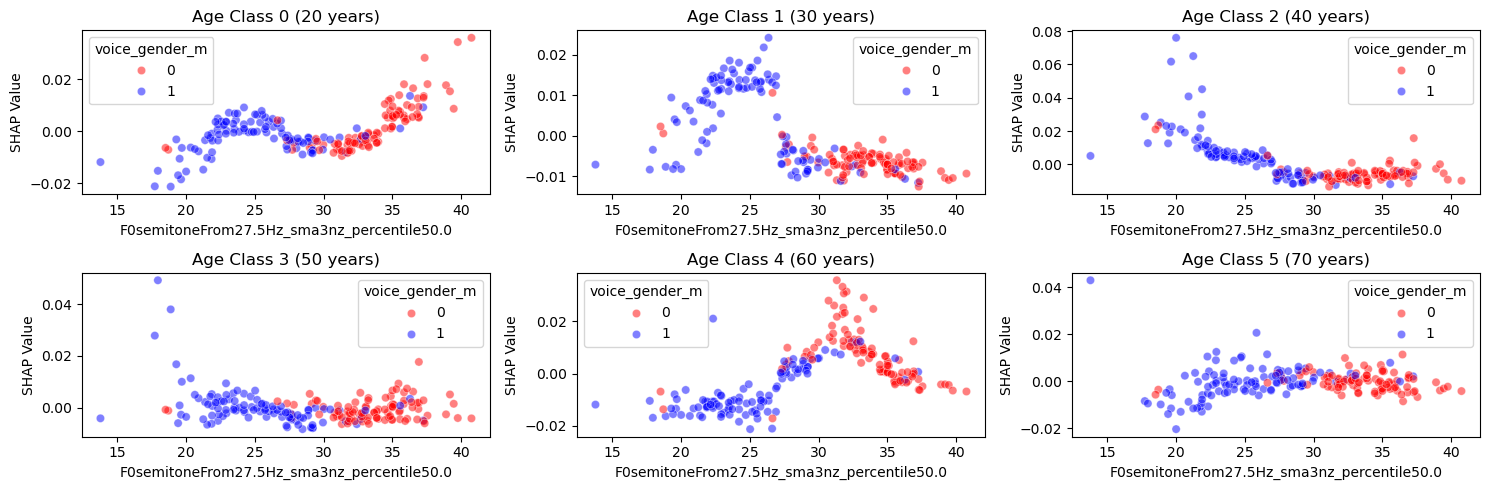

In [35]:
fig, ax = plt.subplots(figsize=(15, 5), ncols=3, nrows=2)

ages = [0, 4]
feature_name = "F0semitoneFrom27.5Hz_sma3nz_percentile50.0"
feature_index = X_g_test.columns.get_loc(feature_name)
gender_index = X_g_test.columns.get_loc("voice_gender_m")

color = X_g_test.iloc[:, gender_index]
age_bin_split = [
    age_bins[:3],
    age_bins[3:6]
]

for j in range(2):
    for age_bin in age_bin_split[j]:
        i = age_bins.index(age_bin)
        x = X_g_test.iloc[:, feature_index]
        y = shap_values_age_gender[:, feature_index, i]
        sns.scatterplot(
            x=x,
            y=y,
            hue=color,
            palette={0: 'red', 1: 'blue'},
            alpha=0.5,
            ax=ax[j][i%3],
            legend=True
        )

        ax[j][i%3].set_title(f"Age Class {i} ({age_bin} years)")
        ax[j][i%3].set_xlabel(feature_name)
        ax[j][i%3].set_ylabel("SHAP Value")

plt.tight_layout()
plt.show()

## GeMaps Feature Definitions

_only the most relevant ones_ (Thanks to \[1\])

|Feature|Definition|
|-|-|
|F0semitoneFrom27.5Hz_sma3nz_percentileX0.0|Pitch, logarithmic F0 on a semitone frequency scale, starting at 27.5 Hz (semitone 0) (Percentile)|
|equivalentSoundLevel_dBp|The equivalent sound level (LEq) is computed by converting the average of the per-frame RMS energies to a logarithmic (dB) scale.|
|slopeV0-500_sma3nz_amean|The spectral slope for the bands 0–500 Hz and 500–1500 Hz is computed from a logarithmic power spectrum by linear least squares approximation|
|alphaRatioUV_sma3nz_amean|Alpha Ratio, ratio of the summed energy from 50–1000 Hz and 1–5 kHz|
|mfcc|The first four Mel-Frequency Cepstral Coefficients (MFCC) (1–4) are computed \[...\] from a 26-band power Mel-spectrum (20–8000 Hz)|


# Refrences

|Num|Ref|
|-|-|
|1| F. Eyben, K. R. Scherer, B. W. Schuller, et al., “The geneva minimalistic acoustic parameter set (GeMAPS) for voice research and affective computing,” IEEE Trans. Affect. Comput., vol. 7, no. 2, pp. 190–202, Apr. 2016. |